# 使用卷积神经网络来改善计算机视觉的精度
主要参考于[DeepLearning.ai课程](https://github.com/lmoroney/dlaicourse)

在上一节中，了解了如何使用包含三层(输入层，隐藏层，输出层)的深度神经网络（DNN）进行识别图片， 并且尝试了不同大小的隐藏层，训练时期数等对最终精度的影响。

为了方便起见，以下是整个代码。运行它并记下最后打印出来的测试准确度

In [3]:
import tensorflow as tf
# 加载数据集(翻墙可以直接下载)
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# 数据预处理
training_images = training_images / 255.0
test_images = test_images / 255.0

# 建立神经网络模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)
])

# 编译神经网络
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',
             metrics= ['accuracy'])

# 训练神经网络
model.fit(training_images, training_labels, epochs = 5)

# 在测试集上评估神经网络的性能
test_loss = model.evaluate(test_images, test_labels)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 78us/sample - loss: 0.4994 - accuracy: 0.8230
Epoch 2/5
60000/60000 [==============================] - 4s 72us/sample - loss: 0.3776 - accuracy: 0.8644
Epoch 3/5
60000/60000 [==============================] - 5s 75us/sample - loss: 0.3396 - accuracy: 0.8767
Epoch 4/5
60000/60000 [==============================] - 5s 84us/sample - loss: 0.3154 - accuracy: 0.8840
Epoch 5/5
10000/10000 [==============================] - 1s 55us/sample - loss: 0.3426 - accuracy: 0.8775


可以观察到，在训练集的准确率大概是89%，在验证集上是87%…不坏…但是你怎么做才能更好呢?一种方法是使用卷积。我不打算在这里详细介绍卷积，但最终的概念是：它们缩小了图像的内容，以集中于特定的、独特的细节

## 1. 卷积神经网络
如果您曾经使用滤波器进行过图像处理。那么卷积看起来会非常熟悉。

简而言之，取一个数组(通常为3x3或5x5)并将其传递到图像上。通过根据矩阵中的公式改变底层像素，您可以完成诸如边缘检测之类的操作。例如，如果你看过此[链接](https://en.wikipedia.org/wiki/Kernel_(image_processing))，你会看到一个为边缘检测而定义的3x3，中间的细胞是8，而它所有的邻居都是-1。在本例中，对于每个像素，将其值乘以8，然后减去每个相邻像素的值。对每个像素都这样做，最终你会得到一个增强了边缘的新图像。

这对于计算机视觉来说是极好的，因为通常可以像这样突出显示特征将一项与另一项区分开，因此所需处理的信息量就少得多了，因为您只是在突出显示的特征上进行训练。

这就是卷积神经网络的概念。在数据进入全连接层之前，添加一些层来做卷积，然后进入密集层的信息会更集中，可能也更准确。

运行下面的代码：这是与前面相同的神经网络，但是这一次首先添加了卷积层。这需要更长的时间，但看看对准确性的影响！

In [10]:
import tensorflow as tf
print(tf.__version__)
# 加载数据集
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
print("trainging_images.shape:",training_images.shape)
# 数据预处理
training_images = training_images.reshape(60000,28,28,1)
training_images = training_images / 255.0
test_images = test_images.reshape(10000,28,28,1)
test_images = test_images / 255.0

# 构建卷积神经网络
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
])

# 编译卷积神经网络
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 查看模型总体参数情况
model.summary()

# 训练卷积神经网络
model.fit(training_images,training_labels,epochs=5)

# 在测试集上评估模型性能
test_loss = model.evaluate(test_images, test_labels)



2.1.0
trainging_images.shape: (60000, 28, 28)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_5 

在训练集数据和验证集数据上，精确度已经上升到93%和91%。这是朝着正确方向迈出的很重要的一步

尝试运行更多的阶段：比如20个，然后观察其结果!虽然在训练集上结果看起来可能很好，但在验证集上结果实际可能会下降，这是由于所谓的“过拟合”，这将在后面讨论。
* “过拟合”发生在网络从训练集很好地学习了数据，但它太过专注于训练集的数据，导致在测试集或者其他数据集上的结果精确度较低。例如，如果你一辈子只看到红色的鞋子，那么当你看到一只红色的鞋子时，你会非常善于识别它，但是蓝色的鞋可能会使你迷惑。

**代码讲解：**
* 1.预处理数据。 您会注意到这里有些变化：需要重新调整训练数据。 那是因为第一个卷积层期望一个包含所有内容的张量，所以我们不能用一个列表中的60,000个28x28x1项，而是要有一个60,000x28x28x1的4D列表，并且对于测试图像而言也是要满足同样的要求。 如果不这样做，则在训练时会出现错误，因为卷积无法识别数据形状。

* 2.构建模型。现在最上面不再是输入层，而是要加一个卷积层。参数是:
 * 1.您要生成的卷积数。 纯粹是任意的，但最好从32左右开始
 * 2.卷积的大小，在这个例子中是3x3网格
 * 3.要使用的激活函数：在本例中，我们将使用relu，它等价于当x>0时返回x，否则返回0
 * 4.第一层的形状是输入数据的形状。

* 然后将在卷积后面跟随一个MaxPooling层，该层然后被设计为压缩图像，同时保持被卷积突出显示的特征的内容。 在本例中，通过为（MaxPooling）指定（2,2），效果是将图像大小缩小四分之一。 其思想是创建一个2x2像素阵列，并选择最大的像素阵列，从而将4个像素变为1。它在整个图像中重复此过程，从而将水平数量减半， 并将垂直像素的数量减半，有效地将图像缩小了25％。
 * 您可以调用model.summary()来查看网络的大小和形状，您会注意到在每个MaxPooling层之后，图像的大小都以这种方式减小了。

* 3.再添加一个卷积层

* 4.现在将卷积层的输出展平。此后将拥有与非卷积版本相同的DNN结构

* 5.和前卷积的例子中一样，有128个稠密层和10个输出层


* 6.现在编译模型，调用拟合方法进行训练，评估测试集的损失和准确性。

## 2. 可视化卷积层和池化层
以下代码将以图形方式向我们展示卷积层输出的图像。
* print (test_labels[;100])向我们显示了测试集中的前100个标签，您可以看到索引0、索引23和索引28处的标签都是相同的值(9)。
* 让我们看一下在它们上面运行卷积的结果，您将开始看到它们之间出现的共同特征。
* 现在，当DNN在这些数据上进行训练时，它会用更少的时间工作，它可能会在鞋子之间找到一个共同点基于卷积和池化的组合。

In [11]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


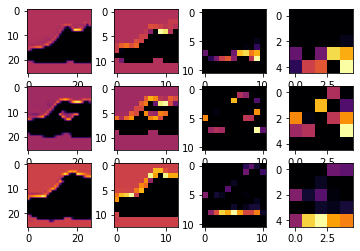

In [14]:
import matplotlib.pyplot as plt
f,axarr = plt.subplots(3,4)
FIRST_IMAGE = 0
SECOND_IMAGE = 23
THIRD_IMAGE = 28
CONVOLUTION_NUMBER = 1
from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input,outputs = layer_outputs)

for x in range(0,4):
    f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1,28,28,1))[x]
    axarr[0,x].imshow(f1[0,:,:, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[0,x].grid(False)
    
    f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[1,x].grid(False)
    
    f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[2,x].grid(False)
    

## 3.练习
* 1.尝试编辑卷积数。把32改成16或者64。这对准确性或训练时间有什么影响?
* 2.删除最后的卷积。 这将对准确性或训练时间产生什么影响？
* 3.增加更多的卷积怎么样?你认为这会有什么影响?
* 4.除去除第一个之外的所有卷积。你认为这会有什么影响?
* 5.在上一课中，您实现了一个回调来检查loss函数，并在达到一定数量时取消训练。看看你能否在这里实现它!

In [19]:
# 练习1测试
import tensorflow as tf
print(tf.__version__)
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=10)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

2.1.0
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 32s 533us/sample - loss: 0.1326 - accuracy: 0.9595
Epoch 2/10
60000/60000 [==============================] - 32s 532us/sample - loss: 0.0455 - accuracy: 0.9858
Epoch 3/10
  544/60000 [..............................] - ETA: 36s - loss: 0.0223 - accuracy: 0.9941

KeyboardInterrupt: 

* 把卷积数从32改成64：训练数据变长，训练集精度到达:99%，测试集精度到达98%
